In [106]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [107]:
'''
    ResNet(2016)
'''

class Residual(nn.Module):
    def __init__(self, input_channels, out_channels, use_1x1conv=False, strides=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                              kernel_size=3, padding=1, stride=1)
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, out_channels,
                                  kernel_size=1, stride=strides)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        Y = F.relu(self.bn1(self.conv1(x)))
        
        Y = self.bn2(self.conv2(Y))
        
        if self.conv3:
            Y += self.conv3(x)
        else:
            Y += x
            
        return F.relu(Y)
        

In [108]:
'''
    GoogleNet(2014)--Inception Block
'''

class Inception(nn.Module):
    def __init__(self, input_channels, c1, c2, c3, c4):
        super(Inception, self).__init__()
        
        self.path_1 = nn.Conv2d(input_channels, c1,
                                kernel_size=1)
        

        self.path_2_1 = nn.Conv2d(input_channels, c2[0],
                                  kernel_size=1)
        self.path_2_2 = nn.Conv2d(c2[0], c2[1],
                                  kernel_size=3, padding=1)
        
        
        self.path_3_1 = nn.Conv2d(input_channels, c3[0],
                                  kernel_size=1)
        self.path_3_2 = nn.Conv2d(c3[0], c3[1], 
                                  kernel_size=5, padding=2)
        
        self.path_4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.path_4_2 = nn.Conv2(input_channels, c4,
                                 kernel_size=1)
        
        
    def forward(self, x):
        Y1 = F.relu(self.path_1(x))
        
        Y2 = F.relu(self.path_2_1(x))
        Y2 = F.relu(self.path_2_2(Y2))
        
        Y3 = F.relu(self.path_3_1(x))
        Y3 = F.relu(self.path_3_2(Y3))
        
        Y4 = F.relu(self.path_4_1(x))
        Y4 = F.relu(self.path_4_2(Y4))
        
        return torch.cat((Y1, Y2, Y3, Y4), dim=1)
        
        
        


In [109]:
# load MINIST dataset

train_data =  torchvision.datasets.MNIST(
    root = './MINIST/',
    train = True,
    transform = torchvision.transforms.ToTensor(),
    download = True
)

test_data = torchvision.datasets.MNIST(
    root = './MINIST/',
    train = False
)

tensor([9, 4, 0])


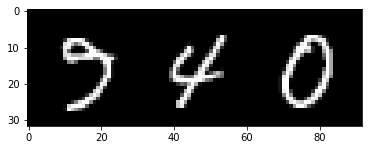

In [110]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=3, shuffle=True)


data_iter = iter(train_loader)
img, label = next(data_iter)
print(label)

img = torchvision.utils.make_grid(img)

plt.imshow(np.transpose(img.numpy(), (1,2,0)))

In [111]:
def ResNet_Block(input_channels, out_channels, num_residuals=2, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, out_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(out_channels, out_channels))
    return blk

In [112]:
b1 = nn.Sequential(nn.Conv2d(1, 8, kernel_size=3, padding=1),
                   nn.BatchNorm2d(8),
                   nn.ReLU())

# b1 output size: 28 x 28
#    channel size: 8

b2 = nn.Sequential(*ResNet_Block(8, 8, first_block=True))

# b2 output size: 28 x 28
#    channel size: 16

b3 = nn.Sequential(*ResNet_Block(8, 16))

b4 = nn.Sequential(*ResNet_Block(16, 32))

In [113]:
ResNet = nn.Sequential(b1, b2, b3, b4,
                       nn.AdaptiveAvgPool2d((1,1)),
                       nn.Flatten(), nn.Linear(32, 10))

In [114]:
X = torch.rand((1,1,28,28))
for layer in ResNet:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 8, 28, 28])
Sequential output shape:	 torch.Size([1, 8, 28, 28])
Sequential output shape:	 torch.Size([1, 16, 14, 14])
Sequential output shape:	 torch.Size([1, 32, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 32, 1, 1])
Flatten output shape:	 torch.Size([1, 32])
Linear output shape:	 torch.Size([1, 10])


In [115]:
test_x = torch.unsqueeze(test_data.data, dim=1).type(torch.FloatTensor)[:2000]/255.
test_y = test_data.targets[:2000]


In [116]:
print(test_y.shape[0])

2000


In [117]:
EPOCHES = 10
BATCH_SIZE = 256
lr = 0.01

train_loader = Data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ResNet.parameters(), lr=lr)

for epoch in range(EPOCHES):
    for step, (x, y) in enumerate(train_loader):
        pred = ResNet(x)
        loss = criterion(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 50 == 0:
            test_pred = ResNet(test_x)
            pred_y = torch.max(test_pred, 1)[1].data.squeeze()
            accuracy = float((pred_y == test_y).sum())/float(test_y.shape[0])
            print('Epoch: ', epoch, '\t train loss: %.4f' % loss.data, '\t test accuracy: %.2f' % accuracy)
            
        


Epoch:  0 	 train loss: 2.3545 	 test accuracy: 0.08
Epoch:  0 	 train loss: 2.1567 	 test accuracy: 0.23
Epoch:  0 	 train loss: 1.9280 	 test accuracy: 0.36
Epoch:  0 	 train loss: 1.7183 	 test accuracy: 0.45
Epoch:  0 	 train loss: 1.5837 	 test accuracy: 0.57
Epoch:  1 	 train loss: 1.4101 	 test accuracy: 0.66
Epoch:  1 	 train loss: 1.1640 	 test accuracy: 0.76
Epoch:  1 	 train loss: 0.9994 	 test accuracy: 0.82
Epoch:  1 	 train loss: 0.7801 	 test accuracy: 0.85
Epoch:  1 	 train loss: 0.7170 	 test accuracy: 0.88
Epoch:  2 	 train loss: 0.5889 	 test accuracy: 0.89
Epoch:  2 	 train loss: 0.6028 	 test accuracy: 0.92
Epoch:  2 	 train loss: 0.4280 	 test accuracy: 0.92
Epoch:  2 	 train loss: 0.3692 	 test accuracy: 0.93


KeyboardInterrupt: 